<a href="https://colab.research.google.com/github/Anisha-Tasneem/Phishing-Email-Detection/blob/main/Random%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Preprocess & Model Train

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import psutil
import time

# Function to preprocess text
def preprocess_text(text):
    # Handle potential non-string values
    if not isinstance(text, str):
        text = str(text)

    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english') and token not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Function to get CPU and RAM usage
def get_cpu_ram_usage():
    cpu_usage = psutil.cpu_percent()
    ram_usage = psutil.virtual_memory().used / (1024 ** 3)  # in GB
    return cpu_usage, ram_usage

# Record CPU and RAM usage before operations
cpu_before_training, ram_before_training = get_cpu_ram_usage()

# Record start time for timing metrics
start_time_data_loading = time.time()

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/CSE445/Phishing_Email.csv')

# Record end time for data loading
end_time_data_loading = time.time()

# Preprocess text data
start_time_preprocessing = time.time()
df['Processed Text'] = df['Email Text'].apply(preprocess_text)
end_time_preprocessing = time.time()

# Split dataset into training and testing sets
X = df['Processed Text']
y = df['Email Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Record start time for training
start_time_training = time.time()

# Train Random Forest classifier
rf_classifier.fit(X_train_tfidf, y_train)

# Record end time for training
end_time_training = time.time()

# Record start time for evaluation
start_time_evaluation = time.time()

# Predict on test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Record end time for evaluation
end_time_evaluation = time.time()

# Record CPU and RAM usage after training
cpu_after_training, ram_after_training = get_cpu_ram_usage()

# Print resource usage and timing metrics
print(f'CPU usage before training: {cpu_before_training}%')
print(f'RAM usage before training: {ram_before_training:.2f} GB')
print(f'CPU usage after training: {cpu_after_training}%')
print(f'RAM usage after training: {ram_after_training:.2f} GB')
print(f'Total data loading time: {end_time_data_loading - start_time_data_loading:.2f} seconds')
print(f'Total preprocessing time: {end_time_preprocessing - start_time_preprocessing:.2f} seconds')
print(f'Total training time: {end_time_training - start_time_training:.2f} seconds')
print(f'Total evaluation time: {end_time_evaluation - start_time_evaluation:.2f} seconds')
print(f'Overall runtime: {end_time_evaluation - start_time_data_loading:.2f} seconds')
print(f'Accuracy: {accuracy * 100:.2f}%')

CPU usage before training: 23.3%
RAM usage before training: 1.43 GB
CPU usage after training: 69.7%
RAM usage after training: 1.53 GB
Total data loading time: 1.51 seconds
Total preprocessing time: 972.10 seconds
Total training time: 18.28 seconds
Total evaluation time: 0.17 seconds
Overall runtime: 996.30 seconds
Accuracy: 95.31%


#  Hyper-parameter space exploration  

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import time
from scipy.stats import randint

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# Perform randomized search to find best hyperparameters
start_time = time.time()
random_search.fit(X_train_tfidf, y_train)
end_time = time.time()

# Print time taken
print(f"Randomized search took {end_time - start_time:.2f} seconds")

# Get best hyperparameters and best score
best_params = random_search.best_params_
best_cv_accuracy = random_search.best_score_

# Evaluate the best model on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f'Best Hyperparameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_cv_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Randomized search took 250.25 seconds
Best Hyperparameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 58}
Best Cross-Validation Accuracy: 94.40%
Test Accuracy: 94.91%


# Learning Curve

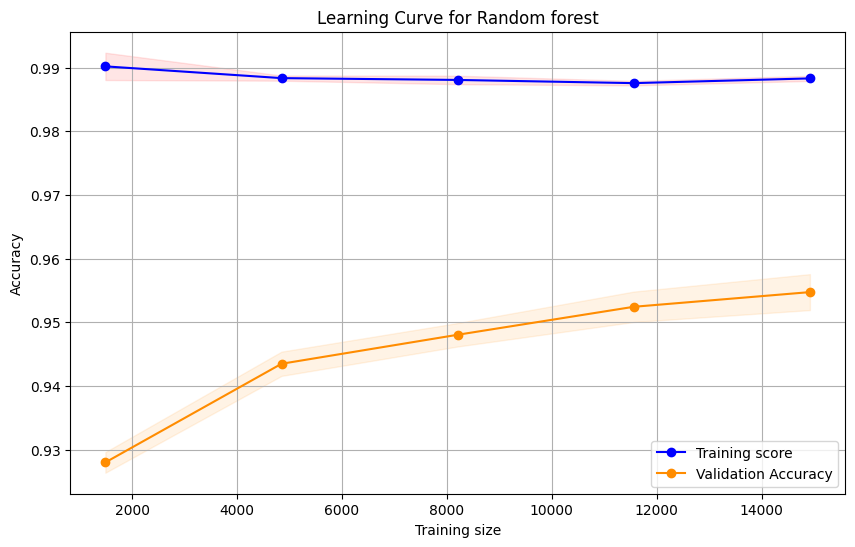

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Combine training and testing data for the learning curve
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

# Convert combined text data to TF-IDF vectors
X_combined_tfidf = vectorizer.fit_transform(X_combined)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Random forest")
plt.xlabel("Training size")
plt.ylabel("Accuracy")

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_combined_tfidf, y_combined, cv=5, n_jobs=1,  # Set n_jobs to 1 to avoid parallel processing issues
    train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="darkorange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="darkorange",
         label="Validation Accuracy")

plt.legend(loc="best")

plt.show()

# Effects of the regularizers

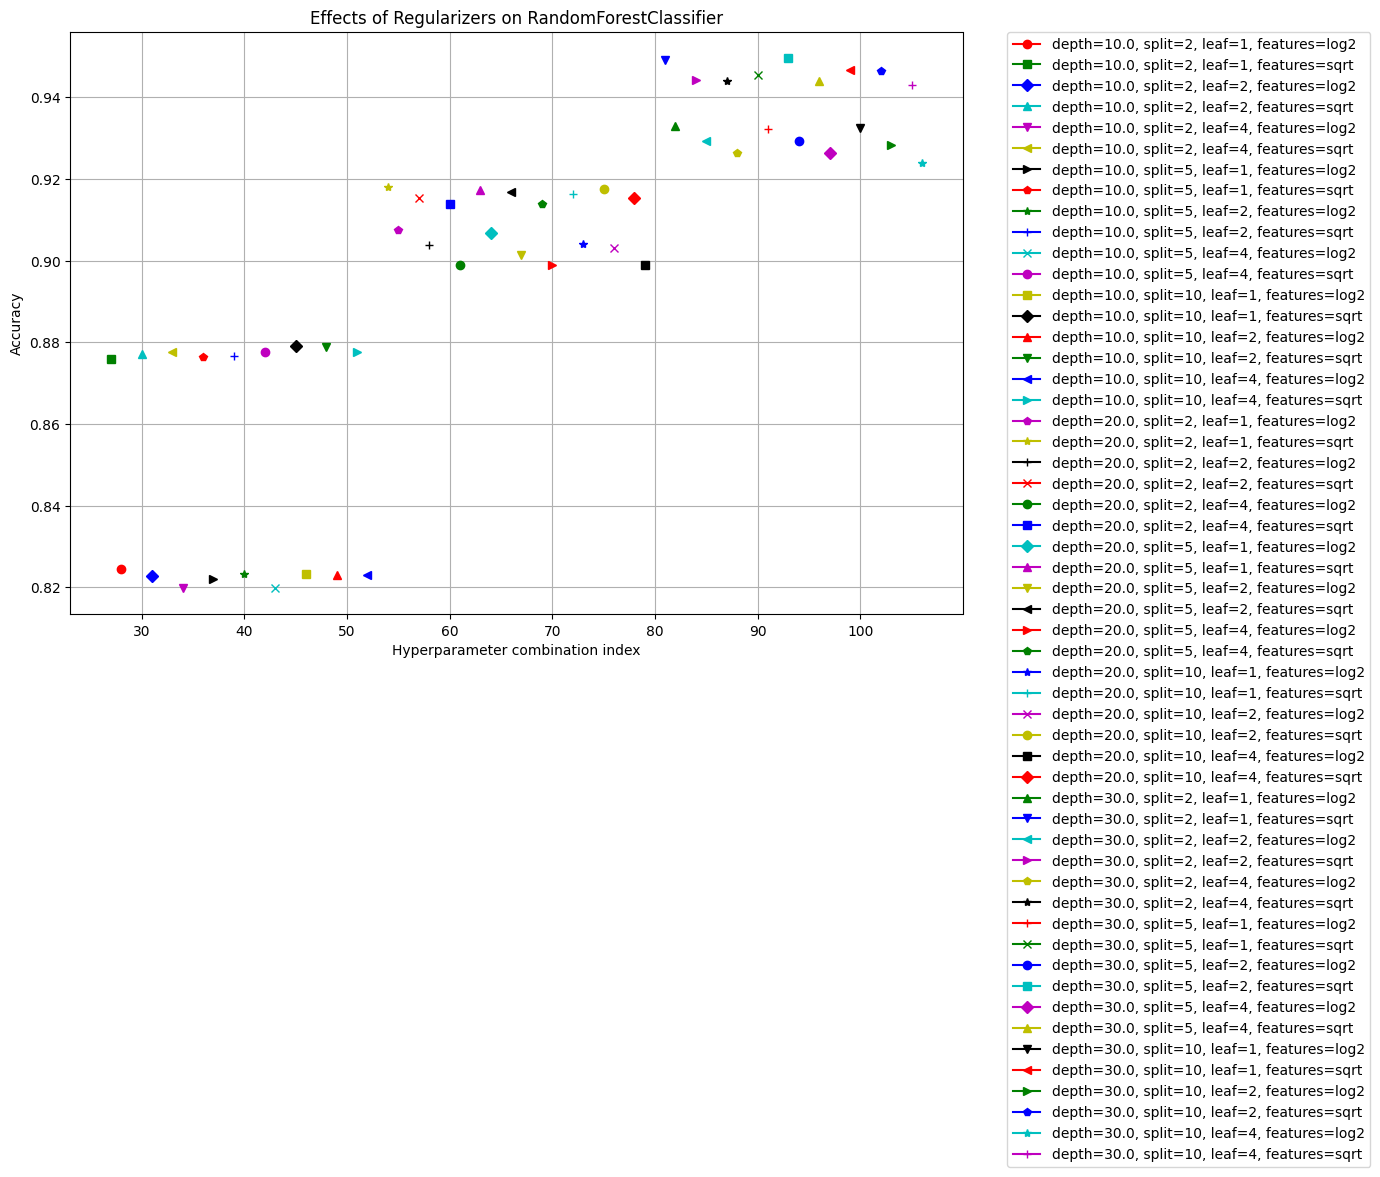

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter grid for the regularizers
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Function to evaluate RandomForest with different hyperparameters
def evaluate_model(param_grid, X_train, y_train, X_test, y_test):
    results = []
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for max_features in param_grid['max_features']:
                    rf_classifier = RandomForestClassifier(
                        n_estimators=100, random_state=42,
                        max_depth=max_depth, min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf, max_features=max_features
                    )
                    rf_classifier.fit(X_train, y_train)
                    y_pred = rf_classifier.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    results.append({
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'max_features': max_features,
                        'accuracy': accuracy
                    })
    return results

# Evaluate the model with different regularizers
results = evaluate_model(param_grid, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Plot the results on a single graph
plt.figure(figsize=(14, 10))
plt.title('Effects of Regularizers on RandomForestClassifier')
plt.xlabel('Hyperparameter combination index')
plt.ylabel('Accuracy')
plt.grid()

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for i, (key, grp) in enumerate(results_df.groupby(['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'])):
    label = f'depth={key[0]}, split={key[1]}, leaf={key[2]}, features={key[3]}'
    plt.plot(grp.index, grp['accuracy'].values, marker=markers[i % len(markers)], color=colors[i % len(colors)], linestyle='-', label=label)

plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [31]:
!pip install --upgrade scikit-learn

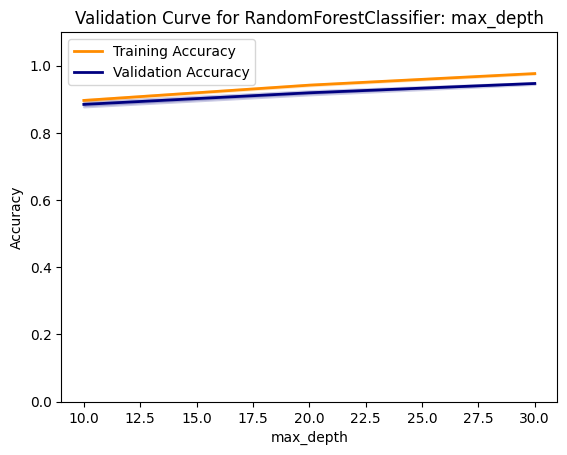

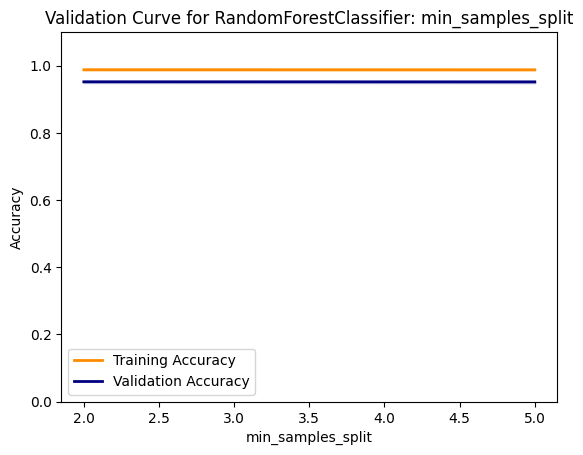

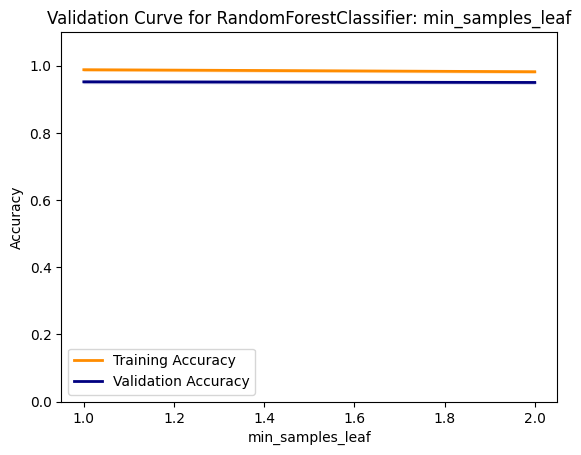

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

# ... (rest of your code)

# Define a narrower range of values for each parameter
param_range_max_depth = [10, 20, 30]
param_range_min_samples_split = [2, 5]
param_range_min_samples_leaf = [1, 2]

# Function to plot validation curve
def plot_validation_curve(estimator, X, y, param_name, param_range, title):
    # Set n_jobs to 1 to disable parallel processing
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training Accuracy",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Validation Accuracy",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

# Assuming best_clf_random is your best RandomForestClassifier model
best_clf_random = RandomForestClassifier(n_estimators=100, random_state=42)

# Example usage for max_depth
title = "Validation Curve for RandomForestClassifier: max_depth"
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="max_depth", param_range=param_range_max_depth, title=title)
plt.show()

# Example usage for min_samples_split
title = "Validation Curve for RandomForestClassifier: min_samples_split"
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="min_samples_split", param_range=param_range_min_samples_split, title=title)
plt.show()

# Example usage for min_samples_leaf
title = "Validation Curve for RandomForestClassifier: min_samples_leaf"
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="min_samples_leaf", param_range=param_range_min_samples_leaf, title=title)
plt.show()

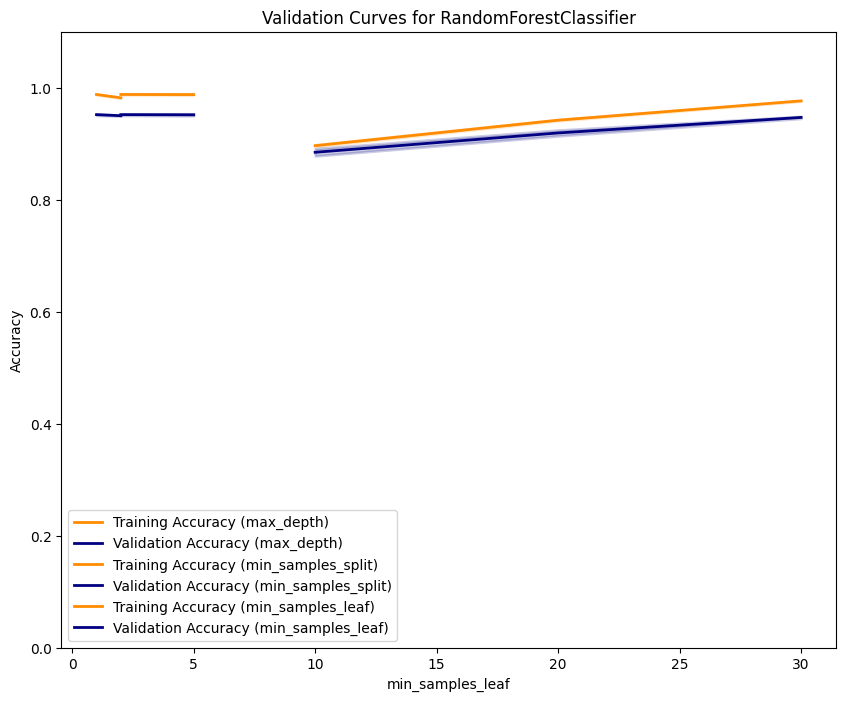

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

# Define a narrower range of values for each parameter
param_range_max_depth = [10, 20, 30]
param_range_min_samples_split = [2, 5]
param_range_min_samples_leaf = [1, 2]

# Function to plot validation curve
def plot_validation_curve(estimator, X, y, param_name, param_range, title):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=1)  # Set n_jobs to 1 for sequential execution
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label=f"Training Accuracy ({param_name})",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label=f"Validation Accuracy ({param_name})",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

# Assuming best_clf_random is your best RandomForestClassifier model
best_clf_random = RandomForestClassifier(n_estimators=100, random_state=42)

# Plotting all validation curves on one graph
plt.figure(figsize=(10, 8))

# Plot validation curve for max_depth
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="max_depth", param_range=param_range_max_depth, title="Validation Curves for RandomForestClassifier")
# Plot validation curve for min_samples_split
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="min_samples_split", param_range=param_range_min_samples_split, title="Validation Curves for RandomForestClassifier")
# Plot validation curve for min_samples_leaf
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="min_samples_leaf", param_range=param_range_min_samples_leaf, title="Validation Curves for RandomForestClassifier")

plt.legend(loc="best")
plt.show()

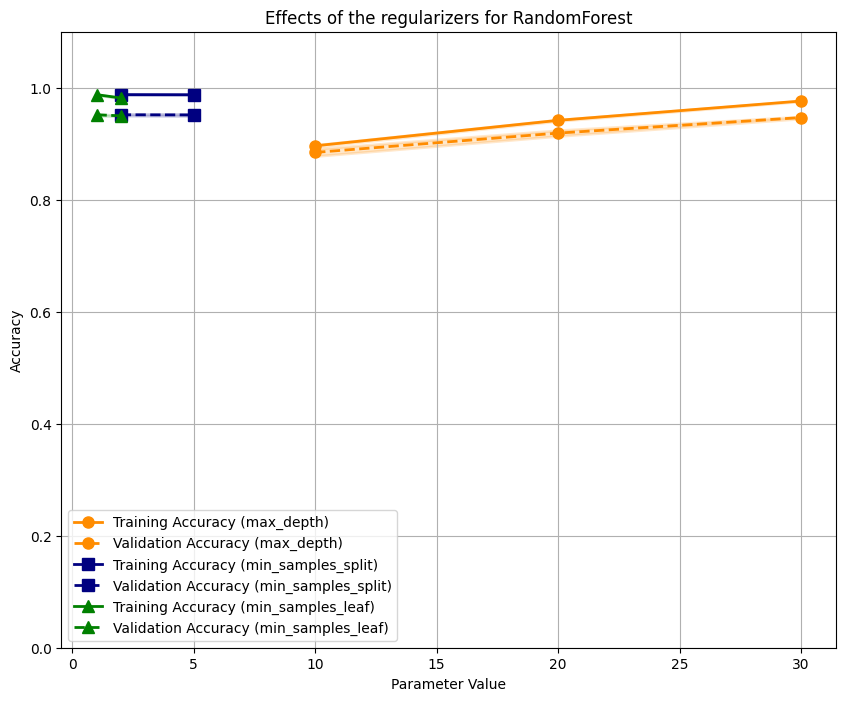

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

# Define a narrower range of values for each parameter
param_range_max_depth = [10, 20, 30]
param_range_min_samples_split = [2, 5]
param_range_min_samples_leaf = [1, 2]

# Define colors and markers for each parameter
colors = ['darkorange', 'navy', 'green']
markers = ['o', 's', '^']

# Function to plot validation curve
def plot_validation_curve(estimator, X, y, param_name, param_range, title, color, marker):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=1)  # Set n_jobs to 1 for sequential execution
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_scores_mean, label=f"Training Accuracy ({param_name})",
             color=color, marker=marker, markersize=8, linestyle='-', linewidth=2)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color=color, lw=2)
    plt.plot(param_range, test_scores_mean, label=f"Validation Accuracy ({param_name})",
             color=color, marker=marker, markersize=8, linestyle='--', linewidth=2)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color=color, lw=2)

# Assuming best_clf_random is your best RandomForestClassifier model
best_clf_random = RandomForestClassifier(n_estimators=100, random_state=42)

# Plotting all validation curves on one graph
plt.figure(figsize=(10, 8))

# Plot validation curve for max_depth
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="max_depth", param_range=param_range_max_depth,
                      title="Validation Curves for RandomForestClassifier", color=colors[0], marker=markers[0])
# Plot validation curve for min_samples_split
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="min_samples_split", param_range=param_range_min_samples_split,
                      title="Validation Curves for RandomForestClassifier", color=colors[1], marker=markers[1])
# Plot validation curve for min_samples_leaf
plot_validation_curve(best_clf_random, X_train_tfidf, y_train, param_name="min_samples_leaf", param_range=param_range_min_samples_leaf,
                      title="Validation Curves for RandomForestClassifier", color=colors[2], marker=markers[2])

plt.xlabel("Parameter Value")
plt.ylabel("Accuracy")
plt.title("Effects of the regularizers for RandomForest")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(0.0, 1.1)
plt.show()

# Accuracy, Precision, Recall, f1-score

In [36]:
from sklearn.metrics import classification_report

# Assuming rf_classifier is your trained RandomForestClassifier model
rf_classifier.fit(X_train_tfidf, y_train)  # Train your model if not already trained

# Predict on test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.93      0.95      0.94      1457
    Safe Email       0.97      0.96      0.96      2273

      accuracy                           0.95      3730
     macro avg       0.95      0.95      0.95      3730
  weighted avg       0.95      0.95      0.95      3730



# Confusion Metrix

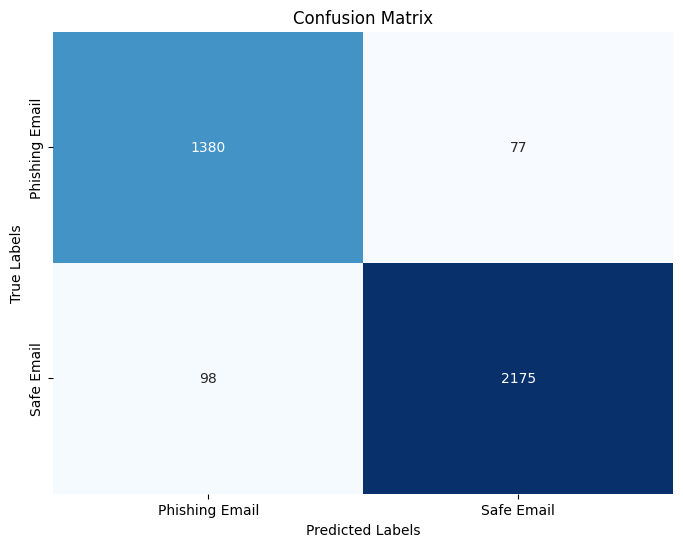

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming rf_classifier is your trained RandomForestClassifier model
rf_classifier.fit(X_train_tfidf, y_train)  # Train your model if not already trained

# Predict on test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# AUC ROC

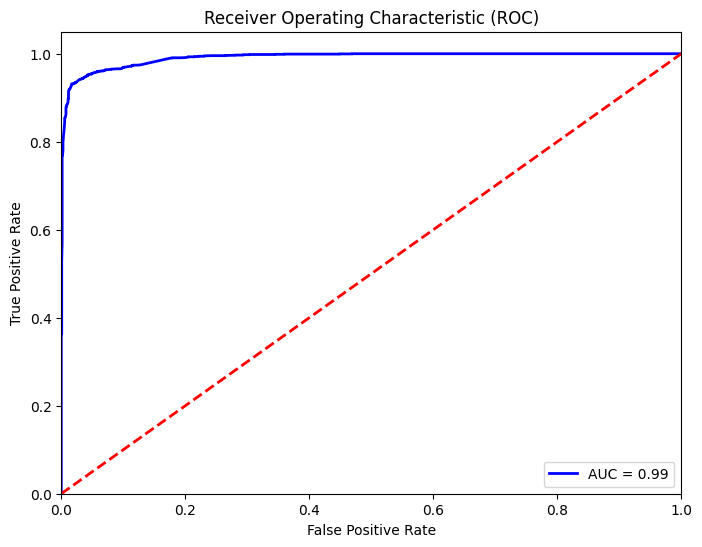

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Assuming rf_classifier is your trained RandomForestClassifier model
rf_classifier.fit(X_train_tfidf, y_train)  # Train your model if not already trained

# Predict probabilities on test set
y_pred_proba = rf_classifier.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (positive class)

# Convert string labels to binary (0 and 1)
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

# Compute ROC curve and AUC using binary labels
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# CPU RAM

In [43]:
import psutil

# Get CPU usage
cpu_usage = psutil.cpu_percent()
print(f'CPU Usage: {cpu_usage}%')

# Get memory usage
memory_info = psutil.virtual_memory()
print(f'Total Memory: {memory_info.total} bytes')
print(f'Used Memory: {memory_info.used} bytes')
print(f'Free Memory: {memory_info.available} bytes')

# Get GPU information (if available)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

CPU Usage: 55.0%
Total Memory: 13609426944 bytes
Used Memory: 2279915520 bytes
Free Memory: 10989072384 bytes


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17239512913086568050
 xla_global_id: -1]